## Red Simple
Con esta red se obtuvo un Accuracy en Test de 0.483. La red consta de 4 capas convolucionales con MaxPooling y 3 capas densas.

In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import tensorflow.compat.v2 as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_datasets as tfds
from keras import backend as K
from tensorflow.python.keras.utils import np_utils
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rn2021q1itba-cifar100/submission_example.csv
/kaggle/input/rn2021q1itba-cifar100/y_train.npy
/kaggle/input/rn2021q1itba-cifar100/x_test.npy
/kaggle/input/rn2021q1itba-cifar100/x_train.npy


### Importación de datos

In [10]:
x_train_val = np.load("/kaggle/input/rn2021q1itba-cifar100/x_train.npy")
x_test = np.load("/kaggle/input/rn2021q1itba-cifar100/x_test.npy")
y_train_val = np.load("/kaggle/input/rn2021q1itba-cifar100/y_train.npy")


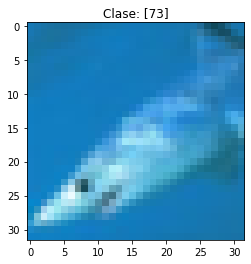

In [11]:
from matplotlib import pyplot as plt
#Mostramos alguna imágen
idx = 50
plt.imshow(x_train_val[idx])
plt.title(f'Clase: {y_train_val[idx]}')
plt.show()

In [12]:
#Dividimos entre train y validación
from sklearn.model_selection import train_test_split

x_train_val = x_train_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train, x_val, y_train, y_val = train_test_split(
     x_train_val, y_train_val, test_size=0.15, random_state=42, stratify=y_train_val)

In [13]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

y_train = np_utils.to_categorical(y_train, 100)
y_val = np_utils.to_categorical(y_val, 100)

### Red de clasificación

In [14]:
#Armamos la red de clasificación
from tensorflow.keras.layers import Dense, Flatten, Activation, BatchNormalization, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator  

In [15]:
model = Sequential()
model.add(Conv2D(64,3, input_shape=(32,32,3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(128,3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(256,3))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(512,3))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.1))

model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(100, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer= Adam(learning_rate=0.001), metrics=["accuracy"])

#### Callbacks

In [ ]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4) 

checkpoint_filepath = '/tmp/checkpoint3'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#### Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)

datagen.fit(x_train)

it_train = datagen.flow(x_train, y_train, batch_size = 64)

#### Entrenamiento

In [16]:
steps = int(x_train.shape[0] / 64)
model.fit(it_train,
         validation_data=(x_val, y_val),
         steps_per_epoch=steps, epochs=200, callbacks=[early_stop, reduce_lr, model_checkpoint_callback])

model.load_weights(checkpoint_filepath)

model.summary()

Epoch 1/200
664/664 [==============================] - 24s 35ms/step - loss: 4.1611 - accuracy: 0.0714 - val_loss: 3.6318 - val_accuracy: 0.1413
Epoch 2/200
664/664 [==============================] - 23s 34ms/step - loss: 3.5018 - accuracy: 0.1634 - val_loss: 3.2177 - val_accuracy: 0.2173
Epoch 3/200
664/664 [==============================] - 23s 35ms/step - loss: 3.1241 - accuracy: 0.2269 - val_loss: 3.4450 - val_accuracy: 0.2159
Epoch 4/200
664/664 [==============================] - 24s 36ms/step - loss: 2.8926 - accuracy: 0.2724 - val_loss: 3.0018 - val_accuracy: 0.2699
Epoch 5/200
664/664 [==============================] - 23s 34ms/step - loss: 2.7370 - accuracy: 0.3011 - val_loss: 2.7116 - val_accuracy: 0.3163
Epoch 6/200
664/664 [==============================] - 23s 34ms/step - loss: 2.6058 - accuracy: 0.3274 - val_loss: 2.6688 - val_accuracy: 0.3244
Epoch 7/200
664/664 [==============================] - 22s 33ms/step - loss: 2.5169 - accuracy: 0.3461 - val_loss: 2.6289 - val_ac

### Test

In [21]:
y_test = model.predict(x_test).argmax(axis=-1)

In [22]:
y_test

array([90, 33, 56, ..., 51, 42, 70])

In [23]:
#Salvo las predicciones y genero el archivo csv según el formato pedido
df = pd.DataFrame(y_test, columns=["label"])
df.index.name = "Id"
df.to_csv("submission4.csv")

In [24]:
df.head()

,label
Id,
0,90
1,33
2,56
3,51
4,71
